In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

In [37]:
import jax
import numpy as np
import matplotlib.pyplot as plt 
import galsim as _galsim


In [38]:
jax.__version__, _galsim.__version__


('0.4.16', '2.5.0')

In [39]:
jax.devices()


[gpu(id=0), gpu(id=1), gpu(id=2), gpu(id=3)]

In [40]:
jax.config.update("jax_default_device", jax.devices()[0])


In [41]:
import jax
import jax.numpy as jnp
import jax_galsim as galsim
from jax import random

from jax import device_get, device_put


In [42]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import random


In [43]:
from tqdm import tqdm


In [44]:
import bpd
from bpd.chains import run_chains
from bpd.draw import add_noise


In [45]:
from numpyro.diagnostics import summary, gelman_rubin, effective_sample_size, print_summary


## Fit single gaussian galaxy with shear (and other parameters)

In [62]:
PSF_HLR = 0.7
PIXEL_SCALE = 0.2
SLEN = 101
BACKGROUND = 1e4

# galaxy
TRUE_HLR = 0.9
LOG_TRUE_FLUX = 4.5
TRUE_FLUX = 10**LOG_TRUE_FLUX
TRUE_X = 0.
TRUE_Y = 0.
 
#shear
G1 = 0.02
G2 = 0.0

#params
TRUE_PARAMS = {'lf': LOG_TRUE_FLUX, 'hlr': TRUE_HLR, 'x': TRUE_X, 'y': TRUE_Y, 'g1': G1, 'g2': G2}
TRUE_PARAMS_ARR = {k:jnp.array([v]) for k,v in TRUE_PARAMS.items()}


In [63]:
# get true image
def _draw_gal():
    gal = _galsim.Gaussian(flux=TRUE_FLUX, half_light_radius=TRUE_HLR)
    gal = gal.shear(g1=G1, g2=G2)
    pos = _galsim.PositionD(x=TRUE_X, y=TRUE_Y)
    psf = _galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = _galsim.Convolve([gal, psf])
    gal_conv = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE, 
                                  offset=pos)
    im = gal_conv.array
    return im


In [64]:
GSPARAMS = galsim.GSParams(minimum_fft_size=512, maximum_fft_size=512)

@jax.jit
@jax.vmap
def draw_gal(lf, hlr, x, y, g1, g2):
    gal = galsim.Gaussian(flux=10**lf, half_light_radius=hlr)
    gal = gal.shear(g1=g1, g2=g2)
    pos = galsim.PositionD(x=x, y=y)
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                                 offset=pos, 
                                 )
    return image.array


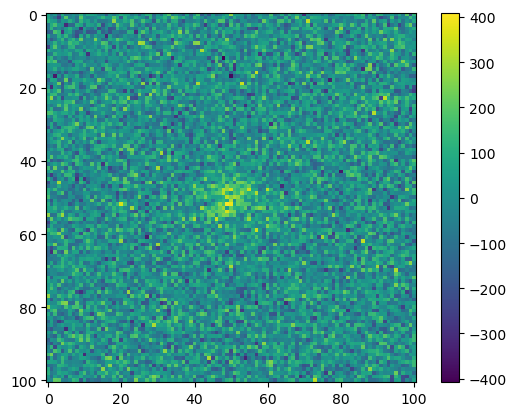

In [65]:
# check error is very small on true thingies
TRUE_IMAGE = _draw_gal()
im, _ = add_noise(TRUE_IMAGE, BACKGROUND)
arr = im
# - draw_gal(**TRUE_PARAMS_ARR)
plt.imshow(arr[0])
plt.colorbar()


In [66]:
x1 = TRUE_IMAGE
np.sqrt(np.sum( (x1 * x1) / (x1 + BACKGROUND)))

18.259981

In [67]:
def prob_model(data):
    batch_dim, _, _ = data.shape
    with numpyro.plate('b', batch_dim, dim=-1):
        lf = numpyro.sample('lf', dist.Uniform(4,6))
        hlr = numpyro.sample('hlr', dist.Uniform(0.5, 1.5))
        x = numpyro.sample('x', dist.Uniform(-0.5, 0.5))
        y = numpyro.sample('y', dist.Uniform(-0.5, 0.5))
        g1 = numpyro.sample('g1', dist.Uniform(-0.1, 0.1))
        g2 = numpyro.sample('g2', dist.Uniform(-0.1, 0.1))
    im = draw_gal(lf, hlr, x, y, g1, g2)
    numpyro.sample('obs', dist.Normal(im, jnp.sqrt(BACKGROUND)), obs=data)


In [87]:
data, _ = add_noise(TRUE_IMAGE, BACKGROUND, n=1)
nuts_kernel = NUTS(prob_model, max_tree_depth=10)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=100, num_chains=1)
rng_key = random.PRNGKey(42)
mcmc.run(rng_key, data=data)


sample: 100%|██████████| 600/600 [00:13<00:00, 43.68it/s, 3 steps of size 5.68e-01. acc. prob=0.89]  


In [88]:
samples = mcmc.get_samples()
samples = {k:v[:,0] for k,v in samples.items()}

In [89]:
print_summary(mcmc.get_samples(), group_by_chain=False)



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     g1[0]      0.02      0.05      0.02     -0.05      0.10     93.93      0.99
     g2[0]     -0.00      0.05     -0.00     -0.10      0.07     96.00      0.99
    hlr[0]      0.95      0.07      0.95      0.84      1.05     62.48      0.99
     lf[0]      4.53      0.03      4.53      4.48      4.57     51.18      0.99
      x[0]      0.08      0.23      0.08     -0.23      0.46    120.66      1.00
      y[0]     -0.20      0.22     -0.24     -0.48      0.15    118.65      0.99



In [77]:
samples['g1'].std()

Array(0.04779349, dtype=float32)

Parameter g2 in chain Posterior is not constrained


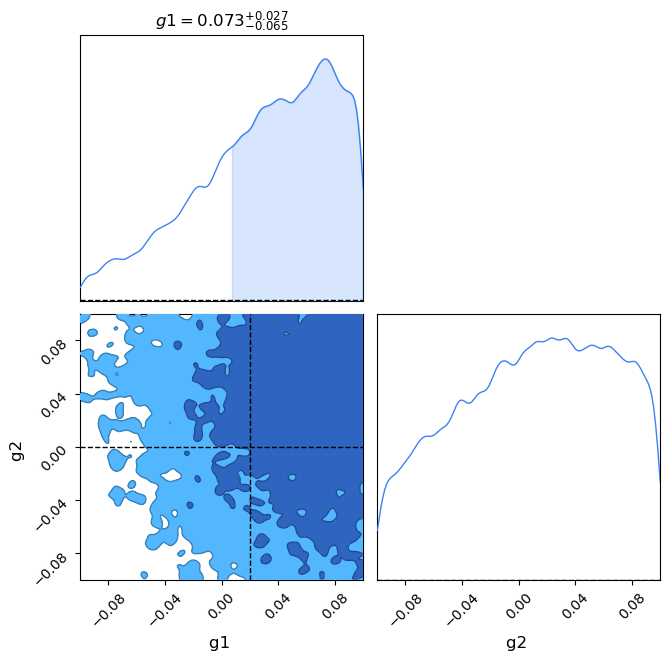

In [75]:
# example of corner plots
from chainconsumer import ChainConsumer, Truth, Chain
import pandas as pd
c = ChainConsumer()
samples = {k:samples[k] for k in ['g1', 'g2']}
df =pd.DataFrame.from_dict(samples)
c.add_chain(
    Chain(samples=df,
    name='Posterior')
)
c.add_truth(Truth(location={'g1':0.02, 'g2':0.0}))
fig = c.plotter.plot()

In [76]:
# collect samples
samples = {p:np.zeros((2000, n_chains*n_vec)) for p in all_samples[0]}
for ii in range(n_chains):
    for p in all_samples[ii]:
        p_ii = all_samples[ii][p]
        samples[p][:, ii*n_vec:(ii+1)*n_vec] = p_ii


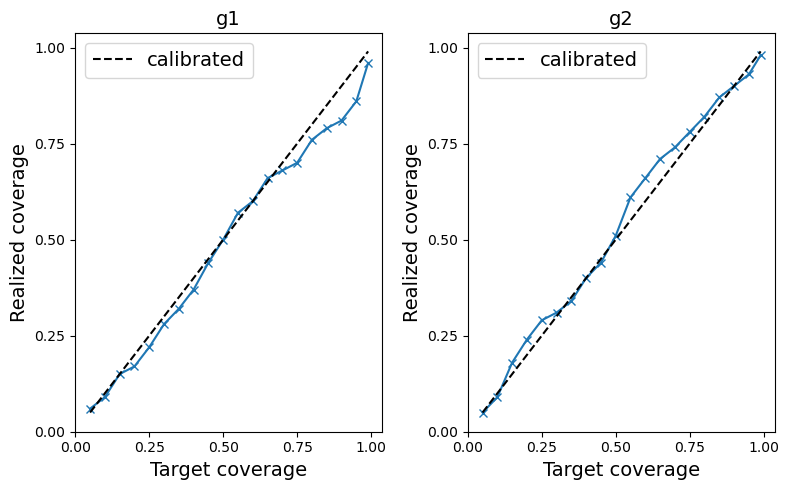

In [84]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,5))
get_pc_fig(samples['g1'], G1, ax1, param='g1')
get_pc_fig(samples['g2'], G2, ax2, param='g2')
plt.tight_layout()


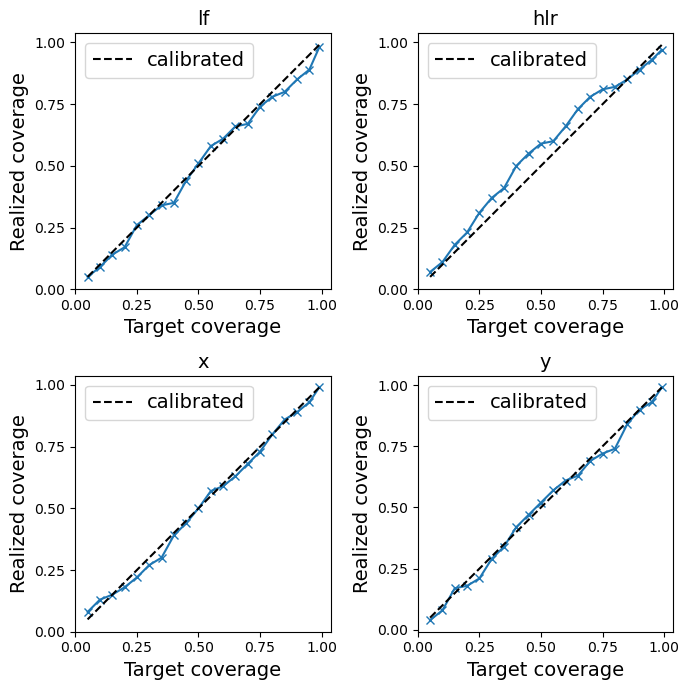

In [90]:
fig, [[ax1, ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(7,7))
get_pc_fig(samples['lf'], LOG_TRUE_FLUX, ax1, param='lf')
get_pc_fig(samples['hlr'], TRUE_HLR, ax2, param='hlr')
get_pc_fig(samples['x'], TRUE_X, ax3, param='x')
get_pc_fig(samples['y'], TRUE_Y, ax4, param='y')
plt.tight_layout()
